The following script generates a data set (with few features (since using subset search)) and uses subset searches to pick a model, comparing penalty based methods (with different lambda) vs cross-validation.

The data sets are random, so each time you run the results will differ.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression #, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
scoring_func = make_scorer(mean_squared_error,greater_is_better=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200


import pandas as pd
from itertools import combinations
from more_itertools import powerset
import operator
import statsmodels.api as sm
import itertools

# Generate a data set

We will use scikit-learn's "make_regression" function to generate data using a linear model.  

Then we will split up the data set into training/test sets using scikit-learn's "train_test_split" which picks a random subset for the test set.

The generated model is random (coefficients will change each time you run).  You can pass an integer seed to the random number generator

### Warning: this script will use best subset search, so make sure the number of features is not too big

In [2]:
from sklearn.datasets import make_regression

n_samples, n_features, n_informative = 100, 10, 5
sigma = 5

#Initialize a random number generator
#pass an integer if you want results to be reproducible
rng = np.random.RandomState() 

X, y,coef_true = make_regression(n_samples, n_features, \
                                 n_informative=n_informative, \
                                 random_state=rng,coef=True, \
                                 noise=sigma, \
                                 effective_rank=n_informative)

print('\nCoefficients in the generative model:')
for i in range(n_features):
    print('\tFeature %2i\'s coefficient: %.2f'%(i,coef_true[i]))
# print(coef_true)

#Split up the big data set into a test set (for final evaluation) and a training set
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.33)




Coefficients in the generative model:
	Feature  0's coefficient: 84.99
	Feature  1's coefficient: 83.28
	Feature  2's coefficient: 45.89
	Feature  3's coefficient: 0.00
	Feature  4's coefficient: 0.00
	Feature  5's coefficient: 0.00
	Feature  6's coefficient: 0.00
	Feature  7's coefficient: 34.41
	Feature  8's coefficient: 0.00
	Feature  9's coefficient: 6.73


# Baselines

#### How good is the true model?

In [3]:
#on test data
y_pred = np.matmul(X_test,coef_true)
mse_test_using_coef_true = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\n\nTest set MSE using true coefficients: %.2f'%mse_test_using_coef_true)

#on training data
y_pred = np.matmul(X_train,coef_true)
mse_train_using_coef_true = mean_squared_error(y_train,y_pred)
# print(mse_train_using_coef_true)
print('\nTraining set MSE using true coefficients: %.2f'%mse_train_using_coef_true)



Test set MSE using true coefficients: 22.16

Training set MSE using true coefficients: 17.11


#### How good is the intercept alone?  (average Y value in the training set)

In [4]:
#on test data
y_pred = np.ones(y_test.shape)*(np.mean(y_train))
mse_test_just_intercept = mean_squared_error(y_test,y_pred)
# print(mse_test_just_intercept)
print('\nTest set MSE using only the intercept: %.2f'%mse_test_just_intercept)

y_pred = np.ones(y_train.shape)*(np.mean(y_train))
mse_train_just_intercept = mean_squared_error(y_train,y_pred)
print('\nTraining set MSE using only the intercept: %.2f'%mse_train_just_intercept)



Test set MSE using only the intercept: 164.43

Training set MSE using only the intercept: 134.20


#### How good is the ordinary least squares (OLS) solution if we use all (training) data for fitting and no penalty?

In [5]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)
mse_test_OLS = mean_squared_error(y_test, pipe.predict(X_test))
mse_train_OLS = mean_squared_error(y_train, pipe.predict(X_train))

print('\nTest set MSE using OLS solution: %.2f'%mse_test_OLS)
print('\nTraining set MSE using OLS solution: %.2f'%mse_train_OLS)



Test set MSE using OLS solution: 19.95

Training set MSE using OLS solution: 14.09


#### How good is the ordinary least squares (OLS) solution if we use use cross validation (fit OLS solution to k-1 folds, evaluate on held out fold, then average)

In [6]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)

parameters = {}
n_folds=5
gs = GridSearchCV(pipe, parameters, \
                  scoring='neg_mean_squared_error', \
                  cv=n_folds)
gs.fit(X_train,y_train)

scores = -gs.cv_results_['mean_test_score']
scores_std = gs.cv_results_['std_test_score']

mse_train_OLS_CV = scores[0] 
#each entry for different parameter, but no paramters passed, so just first entry

print('\nCVTraining set MSE using OLS solution: %.2f'%mse_train_OLS_CV)


CVTraining set MSE using OLS solution: 21.73


### Exhaustive search (best subset search)

First we'll just enumerate different combinations of features

We will call the first feature 1 (consistent with lecture and the book).  However, we'll need to be careful because Python indexing starts from 0.

In [7]:
p = X_train.shape[1] #the number of columns
list_features = range(1,p+1)

print(list_features)

for subset in powerset(list_features):
    print(subset)

range(1, 11)
()
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(7, 8)
(7, 9)
(7, 10)
(8, 9)
(8, 10)
(9, 10)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 2, 10)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 4, 5)
(1, 4, 6)
(1, 4, 7)
(1, 4, 8)
(1, 4, 9)
(1, 4, 10)
(1, 5, 6)
(1, 5, 7)
(1, 5, 8)
(1, 5, 9)
(1, 5, 10)
(1, 6, 7)
(1, 6, 8)
(1, 6, 9)
(1, 6, 10)
(1, 7, 8)
(1, 7, 9)
(1, 7, 10)
(1, 8, 9)
(1, 8, 10)
(1, 9, 10)
(2, 3, 4)
(2, 3, 5)
(2, 3, 6)
(2, 3, 7)
(2, 3, 8)
(2, 3, 9)
(2, 3, 10)
(2, 4, 5)
(2, 4, 6)
(2, 4, 7)
(2, 4, 8)
(2, 4, 9)
(2, 4, 10)
(2, 5, 6)
(2, 5, 7)
(2, 5, 8)
(2, 5, 9)
(2, 5, 10)
(2, 6, 7)
(2, 6, 8)
(2, 6, 9)
(2, 6, 10)
(2, 7, 8)
(2, 7, 

First, we will try using the all training data and adding penalties (AIC, BIC, Cp).  Since the penalties are the same for all models that have the same number of features, we just need to track the best model (in terms of training set MSE) for each cardinality.

In [8]:
model = make_pipeline(StandardScaler(), LinearRegression())

#keep a dictionary, with key as the cardinality and value as 
#  a dictionary with values 'features' (list) and 'trainMSE' (float)
#  initialize with empty set (intercept), calculated above
subsets = {}
subsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept, \
              'AIC':mse_train_just_intercept, 'BIC':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==0:
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in subset) #adjust indexing
    
    X_train_subset = X_train[:,cols]
    
    model.fit(X_train_subset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_subset))
    
    #update if this is the best seen of this cardinality
    k = len(subset)
    
    if k not in list(subsets.keys()):
        #add as currently best
        subsets[k] = {'features':subset, 'trainMSE':mse_train  }
    else:
        if subsets[k]['trainMSE']>mse_train:
            #add as currently best
            subsets[k] = {'features':subset, 'trainMSE':mse_train  }
    
    print('\n'+str(subset)+' '+str(k)+' '+str(mse_train))
       


(1,) 1 66.29534754620491

(2,) 1 112.90987033583161

(3,) 1 122.92828058529497

(4,) 1 134.15137997181543

(5,) 1 134.02411764288868

(6,) 1 121.87398683698135

(7,) 1 133.57525171264342

(8,) 1 109.72654912858897

(9,) 1 130.49835533681846

(10,) 1 120.78636869682528

(1, 2) 2 30.88324593606092

(1, 3) 2 66.19798178625545

(1, 4) 2 66.0808187344845

(1, 5) 2 66.22105680037922

(1, 6) 2 65.61660167455186

(1, 7) 2 64.36078823562359

(1, 8) 2 46.853328552161585

(1, 9) 2 61.57293860611634

(1, 10) 2 52.59855878566312

(2, 3) 2 85.40270134521609

(2, 4) 2 112.3666223662645

(2, 5) 2 112.58819694424119

(2, 6) 2 102.40705466834689

(2, 7) 2 112.11676565009245

(2, 8) 2 99.9208836522348

(2, 9) 2 112.47971764380475

(2, 10) 2 107.37303863782063

(3, 4) 2 122.22363019455817

(3, 5) 2 121.36006555185746

(3, 6) 2 112.55702380255329

(3, 7) 2 120.39036553434711

(3, 8) 2 87.24554447532587

(3, 9) 2 121.09626542235769

(3, 10) 2 110.42511038400731

(4, 5) 2 134.01018453434085

(4, 6) 2 121.80


(2, 5, 6, 10) 4 97.59742293013542

(2, 5, 7, 8) 4 99.55432206536912

(2, 5, 7, 9) 4 111.6469477906262

(2, 5, 7, 10) 4 106.1556481363535

(2, 5, 8, 9) 4 98.88102331793439

(2, 5, 8, 10) 4 95.67128641358073

(2, 5, 9, 10) 4 106.7568745874751

(2, 6, 7, 8) 4 91.51795447922449

(2, 6, 7, 9) 4 101.10349108911957

(2, 6, 7, 10) 4 97.72941682128855

(2, 6, 8, 9) 4 90.39643691762929

(2, 6, 8, 10) 4 88.78088740900273

(2, 6, 9, 10) 4 97.96680808591273

(2, 7, 8, 9) 4 98.78048474845627

(2, 7, 8, 10) 4 95.6785004758026

(2, 7, 9, 10) 4 105.65618329576576

(2, 8, 9, 10) 4 94.55380421655654

(3, 4, 5, 6) 4 112.37245485553392

(3, 4, 5, 7) 4 119.33586030041448

(3, 4, 5, 8) 4 84.5050598031629

(3, 4, 5, 9) 4 119.39017272604161

(3, 4, 5, 10) 4 107.2327687229707

(3, 4, 6, 7) 4 110.3132125779812

(3, 4, 6, 8) 4 80.96989876328202

(3, 4, 6, 9) 4 110.27392621931251

(3, 4, 6, 10) 4 102.45764398781886

(3, 4, 7, 8) 4 76.73163513392686

(3, 4, 7, 9) 4 118.74799685547669

(3, 4, 7, 10) 4 108.396630332

(3, 6, 7, 8, 9) 5 71.80837681431231

(3, 6, 7, 8, 10) 5 70.50718967713756

(3, 6, 7, 9, 10) 5 100.52975724102905

(3, 6, 8, 9, 10) 5 75.92019701751607

(3, 7, 8, 9, 10) 5 74.02023574908014

(4, 5, 6, 7, 8) 5 97.31721347584666

(4, 5, 6, 7, 9) 5 116.4522948084134

(4, 5, 6, 7, 10) 5 111.83438984493777

(4, 5, 6, 8, 9) 5 96.85487790984422

(4, 5, 6, 8, 10) 5 94.9484269136704

(4, 5, 6, 9, 10) 5 108.32970823274336

(4, 5, 7, 8, 9) 5 103.55137380035906

(4, 5, 7, 8, 10) 5 100.45444099303731

(4, 5, 7, 9, 10) 5 116.91417720416348

(4, 5, 8, 9, 10) 5 98.37556736571068

(4, 6, 7, 8, 9) 5 94.23642531986847

(4, 6, 7, 8, 10) 5 93.87979950295767

(4, 6, 7, 9, 10) 5 108.30861066270987

(4, 6, 8, 9, 10) 5 91.6524179471196

(4, 7, 8, 9, 10) 5 97.67506626362972

(5, 6, 7, 8, 9) 5 94.0981922378256

(5, 6, 7, 8, 10) 5 93.53340046632789

(5, 6, 7, 9, 10) 5 108.32752965366228

(5, 6, 8, 9, 10) 5 91.64483318630164

(5, 7, 8, 9, 10) 5 97.59685311203847

(6, 7, 8, 9, 10) 5 90.61767382791595

(1, 2, 3, 4, 5


(1, 3, 4, 5, 7, 8, 10) 7 31.038381055276048

(1, 3, 4, 5, 7, 9, 10) 7 47.81565659180747

(1, 3, 4, 5, 8, 9, 10) 7 32.58096527164646

(1, 3, 4, 6, 7, 8, 9) 7 33.956143780216166

(1, 3, 4, 6, 7, 8, 10) 7 31.124116415976133

(1, 3, 4, 6, 7, 9, 10) 7 47.81693618193094

(1, 3, 4, 6, 8, 9, 10) 7 32.56820671897964

(1, 3, 4, 7, 8, 9, 10) 7 29.221836409731036

(1, 3, 5, 6, 7, 8, 9) 7 33.657452291112186

(1, 3, 5, 6, 7, 8, 10) 7 31.6418341484073

(1, 3, 5, 6, 7, 9, 10) 7 47.947182416036654

(1, 3, 5, 6, 8, 9, 10) 7 33.12491596431226

(1, 3, 5, 7, 8, 9, 10) 7 29.37267006541279

(1, 3, 6, 7, 8, 9, 10) 7 29.41552351572712

(1, 4, 5, 6, 7, 8, 9) 7 36.88028660358942

(1, 4, 5, 6, 7, 8, 10) 7 34.8635850513903

(1, 4, 5, 6, 7, 9, 10) 7 47.76639217647459

(1, 4, 5, 6, 8, 9, 10) 7 33.84884605103639

(1, 4, 5, 7, 8, 9, 10) 7 31.54986892967322

(1, 4, 6, 7, 8, 9, 10) 7 31.880434484686262

(1, 5, 6, 7, 8, 9, 10) 7 31.624115781474675

(2, 3, 4, 5, 6, 7, 8) 7 59.27575654541091

(2, 3, 4, 5, 6, 7, 9) 7 77.59

In [9]:

        cols = tuple(i-1 for i in fsubset) #adjust indexing
    X_train_fsubset = X_train[:,cols]
    model.fit(X_train_fsubset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_fsubset))
    
    
    if len(fsubset)==1:  
        print((str(fsubset)))
        print('\n %.2f  %s'%(mse_train,str(fsubset)))

IndentationError: unexpected indent (<ipython-input-9-289987a5d5e4>, line 2)

In [ ]:
for subset in powerset(list_features):
    if((1) in subset):
       print(subset)

In [10]:
remaining_features = list(list_features)
features = []
MSE_list = [np.inf] #Due to 1 indexing of the loop...

for i in remaining_features:
    print(i)

remaining_features.remove(2)

for i in remaining_features:
    print(i)

1
2
3
4
5
6
7
8
9
10
1
3
4
5
6
7
8
9
10


In [11]:
model = make_pipeline(StandardScaler(), LinearRegression())
fsubsets = {}
fsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept, \
              'AIC':mse_train_just_intercept, 'BIC':mse_train_just_intercept} 

for fsubset in powerset(list_features):
       
    if len(fsubset)==0:
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in fsubset) #adjust indexing
    
    X_train_subset = X_train[:,cols]
    
    model.fit(X_train_subset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_subset))
    
    #update if this is the best seen of this cardinality
    k = len(fsubset)
    if(k>1):
        l = list(fsubset)
        prev = list(fsubsets[k-1]['features'])
        check =  all(item in l for item in prev)
        if(not check):
            continue
    
    if k not in list(fsubsets.keys()):
        #add as currently best
        fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train  }
       
    else:
        if fsubsets[k]['trainMSE']>mse_train:
            #add as currently best
            fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train  }
    
    print('\n'+str(fsubset)+' '+str(k)+' '+str(mse_train))


(1,) 1 66.29534754620491

(2,) 1 112.90987033583161

(3,) 1 122.92828058529497

(4,) 1 134.15137997181543

(5,) 1 134.02411764288868

(6,) 1 121.87398683698135

(7,) 1 133.57525171264342

(8,) 1 109.72654912858897

(9,) 1 130.49835533681846

(10,) 1 120.78636869682528

(1, 2) 2 30.88324593606092

(1, 3) 2 66.19798178625545

(1, 4) 2 66.0808187344845

(1, 5) 2 66.22105680037922

(1, 6) 2 65.61660167455186

(1, 7) 2 64.36078823562359

(1, 8) 2 46.853328552161585

(1, 9) 2 61.57293860611634

(1, 10) 2 52.59855878566312

(1, 2, 3) 3 25.75558041899924

(1, 2, 4) 3 30.316789835788928

(1, 2, 5) 3 28.100412373818585

(1, 2, 6) 3 30.86935530809552

(1, 2, 7) 3 30.378726521023857

(1, 2, 8) 3 24.762901583327725

(1, 2, 9) 3 30.600032414452052

(1, 2, 10) 3 27.107604034216525

(1, 2, 3, 8) 4 16.64818223063194

(1, 2, 4, 8) 4 24.455539484126756

(1, 2, 5, 8) 4 22.408246516568152

(1, 2, 6, 8) 4 24.7614249435259

(1, 2, 7, 8) 4 24.74649414082552

(1, 2, 8, 9) 4 24.19194576608392

(1, 2, 8, 10) 4 

In [12]:
def rpowerset_generator(it, rev=False):
    rn = range(len(it), 0, -1) if rev else range(1, len(it) + 1)
    for r in rn:
        yield from map(list,combinations(it, r))

In [23]:
bsubsets = {}
bsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept, \
              'AIC':mse_train_just_intercept, 'BIC':mse_train_just_intercept}  

for bsubset in rpowerset_generator(list_features, True):
       
    if len(bsubset)==0:
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in bsubset) #adjust indexing
    
    X_train_bsubset = X_train[:,cols]
    
    model.fit(X_train_bsubset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_bsubset))
    
    #update if this is the best seen of this cardinality
    k = len(bsubset)
    if(k<p):
        prev = list(bsubsets[k+1]['features'])
        l = list(bsubset)
        check =  all(item in prev for item in l)
        if(not check):
            continue
            
    if k not in list(bsubsets.keys()):
        #add as currently best
        bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train  }
    else:
        if bsubsets[k]['trainMSE']>mse_train:
            #add as currently best
            bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train  }
    
    print('\n'+str(bsubset)+' '+str(k)+' '+str(mse_train))
       


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 10 14.088159378566841

[1, 2, 3, 4, 5, 6, 7, 8, 9] 9 15.154636584603251

[1, 2, 3, 4, 5, 6, 7, 8, 10] 9 14.090415411719192

[1, 2, 3, 4, 5, 6, 7, 9, 10] 9 22.008419002790696

[1, 2, 3, 4, 5, 6, 8, 9, 10] 9 14.49442117023434

[1, 2, 3, 4, 5, 7, 8, 9, 10] 9 14.091162076097811

[1, 2, 3, 4, 6, 7, 8, 9, 10] 9 14.675458634020965

[1, 2, 3, 5, 6, 7, 8, 9, 10] 9 14.112570547007104

[1, 2, 4, 5, 6, 7, 8, 9, 10] 9 19.539929608464767

[1, 3, 4, 5, 6, 7, 8, 9, 10] 9 29.13695767745123

[2, 3, 4, 5, 6, 7, 8, 9, 10] 9 58.70302043306458

[1, 2, 3, 4, 5, 6, 7, 8] 8 15.168769795309245

[1, 2, 3, 4, 5, 6, 7, 10] 8 22.01661619346179

[1, 2, 3, 4, 5, 6, 8, 10] 8 14.49936760416037

[1, 2, 3, 4, 5, 7, 8, 10] 8 14.09315276616446

[1, 2, 3, 4, 6, 7, 8, 10] 8 14.67551691917497

[1, 2, 3, 5, 6, 7, 8, 10] 8 14.11306193461733

[1, 2, 4, 5, 6, 7, 8, 10] 8 20.018340225328245

[1, 3, 4, 5, 6, 7, 8, 10] 8 31.026243964097958

[2, 3, 4, 5, 6, 7, 8, 10] 8 58.94714653264231

[1, 2, 3, 4, 

Print the results (best of each cardinality).  Also prepare for plotting.

In [21]:
for k in range(p+1):
    subset = subsets[k]['features']
    mse_train = subsets[k]['trainMSE']
    
    print('\n %2i  %.2f  %s'%(k,mse_train,str(subset)))   


  0  134.20  ()

  1  66.30  (1,)

  2  30.88  (1, 2)

  3  24.76  (1, 2, 8)

  4  16.65  (1, 2, 3, 8)

  5  15.03  (1, 2, 3, 8, 10)

  6  14.55  (1, 2, 3, 5, 8, 10)

  7  14.11  (1, 2, 3, 5, 7, 8, 10)

  8  14.09  (1, 2, 3, 4, 5, 7, 8, 10)

  9  14.09  (1, 2, 3, 4, 5, 6, 7, 8, 10)

 10  14.09  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [17]:
print(p)

10


In [15]:
for k in range(p+1):
    fsubset = fsubsets[k]['features']
    mse_train = fsubsets[k]['trainMSE']
    
    print('\n %2i  %.2f  %s'%(k,mse_train,str(fsubset)))  


  0  134.20  ()

  1  66.30  (1,)

  2  30.88  (1, 2)

  3  24.76  (1, 2, 8)

  4  16.65  (1, 2, 3, 8)

  5  15.03  (1, 2, 3, 8, 10)

  6  14.55  (1, 2, 3, 5, 8, 10)

  7  14.11  (1, 2, 3, 5, 7, 8, 10)

  8  14.09  (1, 2, 3, 4, 5, 7, 8, 10)

  9  14.09  (1, 2, 3, 4, 5, 6, 7, 8, 10)

 10  14.09  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [25]:
for k in range(p+1):
    bsubset = bsubsets[k]['features']
    mse_train = bsubsets[k]['trainMSE']
    
    print('\n %2i  %.2f  %s'%(k,mse_train,str(bsubset)))  


  0  134.20  ()

  1  66.30  [1]

  2  30.88  [1, 2]

  3  24.76  [1, 2, 8]

  4  16.65  [1, 2, 3, 8]

  5  15.03  [1, 2, 3, 8, 10]

  6  14.55  [1, 2, 3, 5, 8, 10]

  7  14.11  [1, 2, 3, 5, 7, 8, 10]

  8  14.09  [1, 2, 3, 4, 5, 7, 8, 10]

  9  14.09  [1, 2, 3, 4, 5, 6, 7, 8, 10]

 10  14.09  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


_Question_: Look at the subsets.  Do you see nesting?  If so, are the subsets fully nested?

_Question_: Since you generated the data, you know the true model.  Was it included above?

#### Add penalties

We will now add penalties, AIC and BIC. (Mallow's Cp and AIC same for this model class)  See (6.2) and (6.3) in the book for the formulas.

The best subsets (for each cardinality) will be the same, since the penalties are constant with respect to cardinality.

In [261]:
trainMSE_vals = []#save for plotting
AIC_vals = [] 
BIC_vals = []
ftrainMSE_vals = []#save for plotting
fAIC_vals = [] 
fBIC_vals = []
btrainMSE_vals = []#save for plotting
bAIC_vals = [] 
bBIC_vals = []

for k in range(p+1):
    subset = subsets[k]['features']
    fsubset = fsubsets[k]['features']
    bsubset = bsubsets[k]['features']
    mse_train = subsets[k]['trainMSE']
    fmse_train = fsubsets[k]['trainMSE']
    bmse_train = bsubsets[k]['trainMSE']
    
    noise_var_estimate = subsets[p]['trainMSE'] #use the model with all predictors
    fnoise_var_estimate = fsubsets[p]['trainMSE'] #use the model with all predictors
    bnoise_var_estimate = bsubsets[p]['trainMSE'] #use the model with all predictors
    
    n_train_samples = X_train.shape[0]
    
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    fAIC_penalty = 2*k*fnoise_var_estimate/n_train_samples
    bAIC_penalty = 2*k*bnoise_var_estimate/n_train_samples
    subsets[k]['AIC'] = mse_train+AIC_penalty
    fsubsets[k]['AIC'] = fmse_train+fAIC_penalty
    bsubsets[k]['AIC'] = bmse_train+bAIC_penalty
    
    BIC_penalty = np.log(n_train_samples)*k*noise_var_estimate/n_train_samples
    fBIC_penalty = np.log(n_train_samples)*k*fnoise_var_estimate/n_train_samples
    bBIC_penalty = np.log(n_train_samples)*k*bnoise_var_estimate/n_train_samples
    subsets[k]['BIC'] = mse_train+BIC_penalty
    fsubsets[k]['BIC'] = fmse_train+fBIC_penalty
    bsubsets[k]['BIC'] = bmse_train+bBIC_penalty
    
    trainMSE_vals.append(subsets[k]['trainMSE'])
    ftrainMSE_vals.append(fsubsets[k]['trainMSE'])
    btrainMSE_vals.append(bsubsets[k]['trainMSE'])
    AIC_vals.append(subsets[k]['AIC'])
    fAIC_vals.append(fsubsets[k]['AIC'])
    bAIC_vals.append(bsubsets[k]['AIC'])
    BIC_vals.append(subsets[k]['BIC'])
    fBIC_vals.append(fsubsets[k]['BIC'])
    bBIC_vals.append(bsubsets[k]['BIC'])

In [262]:
X_train.shape[0]

67

In [271]:
print(AIC_vals.index(min(AIC_vals))


SyntaxError: unexpected EOF while parsing (<ipython-input-271-2ea49d529703>, line 1)

Make a plot of the training MSE as a function of the cardinality

Recall that for each cardinality, we already picked the best (in terms of training set MSE)

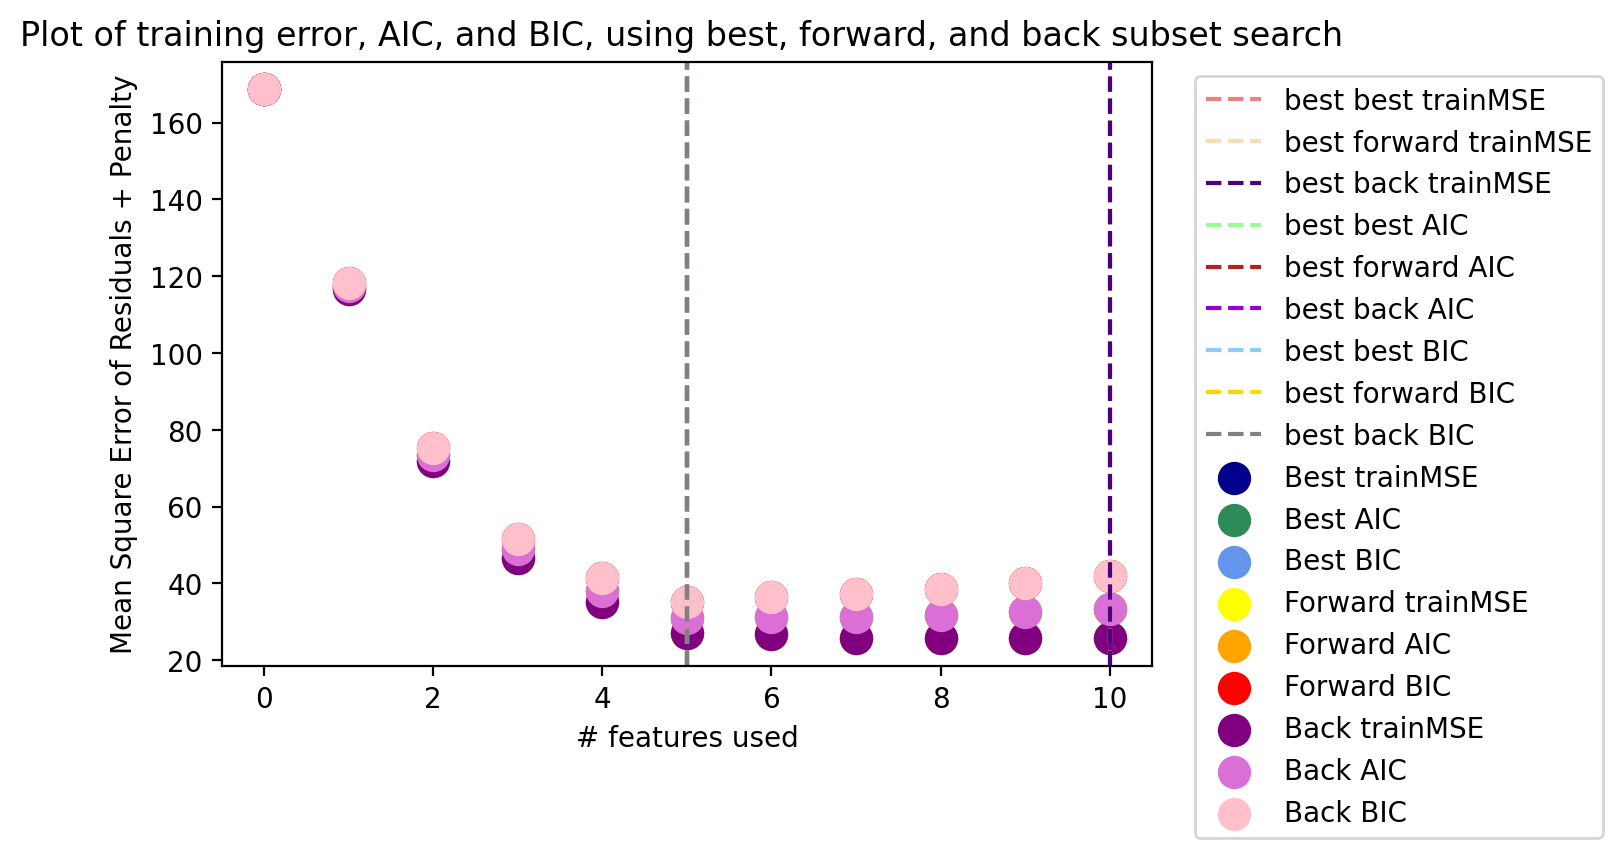

In [263]:
#now plot training error
plt.figure()
cardinalities = range(p+1)
plt.scatter(cardinalities, trainMSE_vals,color='darkblue',linewidth=6,label='Best trainMSE')
plt.scatter(cardinalities, AIC_vals,color='seagreen',linewidth=6,label='Best AIC')
plt.scatter(cardinalities, BIC_vals,color='cornflowerblue',linewidth=6,label='Best BIC')
plt.scatter(cardinalities, ftrainMSE_vals,color='yellow',linewidth=6,label='Forward trainMSE')
plt.scatter(cardinalities, fAIC_vals,color='orange',linewidth=6,label='Forward AIC')
plt.scatter(cardinalities, fBIC_vals,color='red',linewidth=6,label='Forward BIC')
plt.scatter(cardinalities, btrainMSE_vals,color='purple',linewidth=6,label='Back trainMSE')
plt.scatter(cardinalities, bAIC_vals,color='orchid',linewidth=6,label='Back AIC')
plt.scatter(cardinalities, bBIC_vals,color='pink',linewidth=6,label='Back BIC')
plt.title('Plot of training error, AIC, and BIC, using best, forward, and back subset search ')
plt.xlabel("# features used")
plt.ylabel("Mean Square Error of Residuals + Penalty")

#Mark the value of the best MSE
plt.axvline(trainMSE_vals.index(min(trainMSE_vals)), linestyle='--', \
            color='lightcoral',label=r'best best trainMSE')
plt.axvline(ftrainMSE_vals.index(min(ftrainMSE_vals)), linestyle='--', \
            color='wheat',label=r'best forward trainMSE')
plt.axvline(btrainMSE_vals.index(min(btrainMSE_vals)), linestyle='--', \
            color='indigo',label=r'best back trainMSE')

#Mark the value of the best AIC
plt.axvline(AIC_vals.index(min(AIC_vals)), linestyle='--', \
            color='palegreen',label=r'best best AIC')
plt.axvline(fAIC_vals.index(min(fAIC_vals)), linestyle='--', \
            color='firebrick',label=r'best forward AIC')
plt.axvline(bAIC_vals.index(min(bAIC_vals)), linestyle='--', \
            color='darkviolet',label=r'best back AIC')

#Mark the value of the best BIC
plt.axvline(BIC_vals.index(min(BIC_vals)), linestyle='--', \
            color='lightskyblue',label=r'best best BIC')
plt.axvline(fBIC_vals.index(min(fBIC_vals)), linestyle='--', \
            color='gold',label=r'best forward BIC')
plt.axvline(bBIC_vals.index(min(bBIC_vals)), linestyle='--', \
            color='grey',label=r'best back BIC')

#plt.ylim(0,50)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
# plt.xlim(-0.5, p+10)
plt.show()

### What if we used held out data instead for choosing among different subsets?